# ML TDOA-Based Source Localization

In this notebook we perform Sound Source Localization using the maximum likelihood method. Consider the $\boldsymbol{i^{th}}$ pair of microphones with spatial coordinates denoted by the 3-element vectors, $\boldsymbol{p_{i1}}$ and $\boldsymbol{p_{i2}}$, respectively. For a signal source with known spatial location, $\boldsymbol{q_s}$, the true **TDOA** relative to the $\boldsymbol{i^{th}}$ sensor pair will be
denoted by $T((p_{i2}, p_{i2}), q_s)$, and is calculated from the expression : $\displaystyle T((p_{i2}, p_{i2}), q_s) = \frac{\left|{q_s - p_{i2}}\right| - \left|{q_s - p_{i1}}\right|}{c}$. The **TDOA** estimate $\boldsymbol{\hat\tau_i}$ is computed using the GCC-PHAT. 

If the time-delay estimates at each microphone pair are assumed to be independently corrupted by zero- mean additive white Gaussian noise of equal variance then the ML location estimate can be shown to be the position which minimizes the least squares error criterion. Given a set of M TDOA estimates derived from the signals received at multiple pairs of microphones, the LS-criterion can be expressed as  $\displaystyle E(\boldsymbol{q}) = \sum_{i=1}^{M} (\hat\tau_i - T((p_{i2}, p_{i2}), q_s))^2 $. The location estimate is then found from :  $\boldsymbol{\hat{q_s}} = \underset{q}{\operatorname{argmin}} E(\boldsymbol{q})$


*References* : [Microphone arrays : signal processing techniques and applications, Chapter 8 (Robust Localization in Reverberant Rooms)](https://beast-epfl.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=TN_ebi01_prod004161025&context=P2P&vid=EPFL&lang=fr_FR&search_scope=default_scope&adaptor=Primo2Primo_41EPFL&tab=default_tab&query=any,contains,microphone%20array%20signal%20processing&sortby=rank&offset=0)

1. [Room setup](#rset)
2. [Computation of ground truth and estimate TDOAs](#comp)
3. [Minimization of the LS-Criterion](#min)

In [1]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import math, random
from tqdm import tqdm
from helpers_ml import *
from skopt import gp_minimize
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

<a id='rset'></a>
### 1. Room setup

**Shoe Box Room**

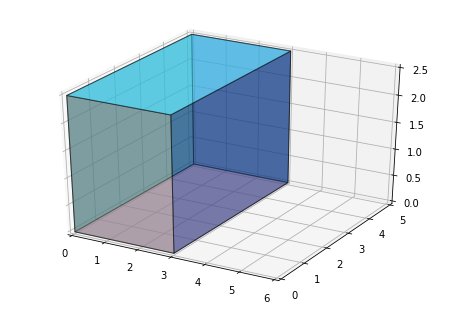

In [2]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 3, 5, 2.5
room_dim = np.array([room_dimX, room_dimY, room_dimZ])

#Sampling frequency
fs = 16000 # 16kHz

room = pra.ShoeBox(room_dim, fs=fs, max_order = 4, absorption=0.2)

# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 5])
ax.set_zlim([0, 2.5]);

**L-Shape Room**

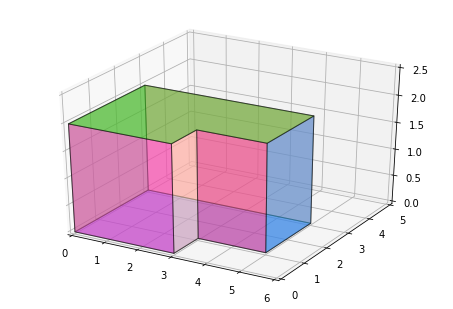

In [3]:
# Create a 3D L-Shaped room 
corners = np.array([[0, 0], [0, 3], [5, 3], [5, 1], [3, 1], [3, 0]]).T # [x, y]
room = pra.Room.from_corners(corners, fs=fs, max_order= 4, absorption=0.2)
room.extrude(2.)
# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 5])
ax.set_zlim([0, 2.5]);

Create and visualize microphone array

In [13]:
n_mics = 20
radius = 0.1 #radius of the sphere in meters
mics_pos = sphere_micsArray(n_mics, [4*2, 2*2, 2*1], radius=0.01)
#mics_pos = sphere_micsArray(n_mics, room_dim, radius=0.01)


# the fs of the microphones is the same as the room
mic_array = pra.MicrophoneArray(mics_pos.T, room.fs)
room.add_microphone_array(mic_array)

In [14]:
mics_pos.shape

(20, 3)

Visualize mic array

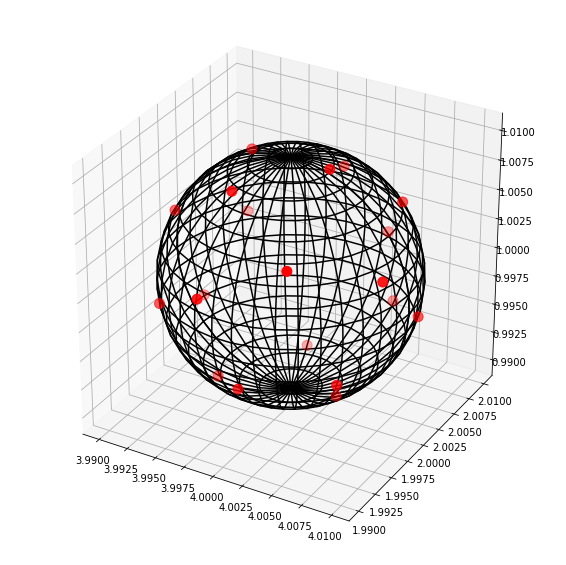

In [15]:
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)

x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

norm = np.sqrt(x**2 + y**2 + z**2)
x /= 100*norm
y /= 100*norm
z /= 100*norm

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
fig.set_size_inches(10,10,10)
#ax.plot_wireframe(x + room_dim[0]/2, y + room_dim[1]/2, z + room_dim[2]/2, color='k', rstride=1, cstride=1)
ax.plot_wireframe(x + 4, y + 2, z + 1, color='k', rstride=1, cstride=1)
ax.scatter(mics_pos[:,0], mics_pos[:,1], mics_pos[:,2], s=100, c='r', zorder=10)

Add source and simulate sound propagation

In [22]:
# Add source of 5 seconds duration 
rng = np.random.RandomState(23) 
duration_samples = 5*int(fs) 
# White noise
source_signal = rng.randn(duration_samples)

source_X, source_Y, source_Z  = 2.5, 0.5, 1

source_location = [source_X, source_Y, source_Z]

room.add_source(source_location, signal=source_signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

rir = room.rir
room.simulate()

In [23]:
room.mic_array.signals.shape

(5, 80944)

<a id='comp'></a>
### 2. Computation of ground truth and estimated TDOAs

In [24]:
tdoa_gt, tdoa_estimates = compute_trueTDOA_estimateTDOA(source_location, mics_pos, room.mic_array.signals, fs, 2*radius/343.0)

100%|██████████| 5/5 [00:47<00:00,  9.51s/it]


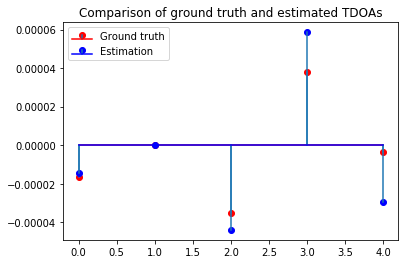

In [25]:
markerline1, stemlines, _  = plt.stem(tdoa_gt, markerfmt='ro', basefmt='r-')
plt.setp(markerline1, 'markerfacecolor', 'r')
markerline2, stemlines, _ = plt.stem(tdoa_estimates, markerfmt='bo', basefmt='b-')
plt.setp(markerline2, 'markerfacecolor', 'b')
plt.legend(('Ground truth', 'Estimation'), loc=0)
plt.title('Comparison of ground truth and estimated TDOAs')
plt.show()

<a id='min'></a>
### 3. Minimization of the LS-Criterion

In [26]:
M = 5 #number of microphones
c = 343.0 #sound speed

indexes_1 = np.random.randint(0, n_mics, size=M)
indexes_2 = np.random.randint(0, n_mics, size=M)

tdoa_estimates = compute_tdoa_estimates(room.mic_array.signals, indexes_1, indexes_2, fs, 2*radius/c, M=M)

100%|██████████| 5/5 [00:49<00:00,  9.92s/it]


In [36]:
def ls_criterion(src_pos):
    E = 0
    tdoa_gt = compute_M_tdoa(src_pos, mics_pos, indexes_1, indexes_2)
    for i in range(M):
        E += 1e11*(tdoa_estimates[i] - tdoa_gt[i])**2
    
    return E

initial_guess = np.random.randint(1,min(room_dimX, room_dimY , room_dimZ)+1, size=3)
y0 = ls_criterion(initial_guess)
result = gp_minimize(ls_criterion, ((0.0, room_dimX), (0.0, room_dimY), (0.0, room_dimZ)), x0=list(initial_guess), 
                     y0=y0, n_calls=50)

In [37]:
result.x

[0.043438752742179745, 0.0, 0.0]

In [38]:
print('L2 Distance between ground truth position and recovered postion is: {pos} cm'.format(pos=100*np.linalg.norm(np.array(source_location) - result.x)))

L2 Distance between ground truth position and recovered postion is: 269.90170732192297 cm


cubic room symetries problem try with rectangular room, put microphone randomly